Load package

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision

## Download dataset and required packages if necessary
!pip install git+https://github.com/neurallatents/nlb_tools.git

## Imports
# %matplotlib widget # uncomment for interactive plots
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/neurallatents/nlb_tools.git to /tmp/pip-req-build-3dj8n2ys
  Running command git clone -q https://github.com/neurallatents/nlb_tools.git /tmp/pip-req-build-3dj8n2ys
     |████████████████████████████████| 11.3 MB 4.6 MB/s 
     |████████████████████████████████| 126 kB 75.3 MB/s 
     |████████████████████████████████| 187 kB 71.3 MB/s 
     |████████████████████████████████| 109 kB 70.0 MB/s 
     |████████████████████████████████| 500 kB 72.5 MB/s 
  Created wheel for nlb-tools: filename=nlb_tools-0.0.1-py3-none-any.whl size=32989 sha256=16015b9cb1459cf2cd764546b916f6794fd8b4a4868bc5df2418ab6447efc989
  Stored in directory: /tmp/pip-ephem-wheel-cache-z0q30c8d/wheels/2a/e3/dc/2d4b1ad404062cfe0a6b190a5ea438d97d3a82a023eb5f6e8b
Successfully built nlb-tools
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5

In [3]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

In [31]:
def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    batch_size = inputs.size(axis=0)
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn +h1[:,t] + torch.einsum("ac,cd->ad", (out, v))
        new_mem = (beta*mem +syn)*(1.0-rst)

        mem_rec.append(mem)
        spk_rec.append(out)
        
        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    # out_rec = [out]
    out_rec = []
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

Check and use GPU

In [5]:
dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")

In [11]:
def BCI_dataset(dataset, batch_length, time_lag):

    # data_set: NWB dataset
    # batch_length: length of each batch size in ms
    # time_lag: lag between the spike times and the velocity measurements in ms

    spike_times = np.asarray(dataset.data.spikes)
    velocity = np.asarray(dataset.data.finger_vel)
    position = np.asarray(dataset.data.finger_pos)[:, :2]

    print(np.shape(position))

    if time_lag != 0:
      spike_times = spike_times[:-time_lag, :]
      velocity = velocity[time_lag:, :]

    len_spike_times = len(spike_times)
    nb_batches = int(len_spike_times/batch_length)

    input_data = []
    target_data = []
    for i in range(nb_batches):
      input_data.append(spike_times[batch_length * i:(i+1) * batch_length , :])
        # target_data.append(np.hstack((velocity[batch_length * i:(i+1) * batch_length , :],position[batch_length * i:(i+1) * batch_length , :])))
      target_data.append(velocity[batch_length * i:(i+1) * batch_length , :])


    input_data = np.asarray(input_data)
    target_data = np.asarray(target_data)


    return input_data, target_data

In [42]:
## Download dataset and required packages if necessary
!pip install git+https://github.com/neurallatents/nlb_tools.git

## Imports
# %matplotlib widget # uncomment for interactive plots
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import pandas as pd

batch_size_train = 75
batch_size_test = 25

## Load dataset
dataset = NWBDataset('/content/drive/MyDrive/sub-Indy_desc-train_behavior+ecephys.nwb', split_heldout=False)
input_data, target_data = BCI_dataset(dataset = dataset, batch_length = 2500, time_lag = 50)
input_data[np.isnan(input_data)] = 0
target_data[np.isnan(target_data)] = 0


input_data_train = input_data[0:batch_size_train,:,:]
input_data_test = input_data[batch_size_train:batch_size_train + batch_size_test,:,:]

target_data_train = target_data[0:batch_size_train,:,:]
target_data_test = target_data[batch_size_train:batch_size_train + batch_size_test,:,:]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/neurallatents/nlb_tools.git to /tmp/pip-req-build-js6xyw9q
  Running command git clone -q https://github.com/neurallatents/nlb_tools.git /tmp/pip-req-build-js6xyw9q
(649100, 2)


In [43]:
x_train = torch.tensor(input_data_train,dtype=dtype).to(device)
y_train = torch.tensor(target_data_train / 200, dtype=dtype).to(device)

x_test = torch.tensor(input_data_test,dtype=dtype).to(device)
y_test = torch.tensor(target_data_test / 200, dtype=dtype).to(device)

print(x_train.size())

torch.Size([75, 2500, 130])


Define network parameters

In [44]:
# The coarse network structure is dicated by the Fashion MNIST dataset. 
nb_inputs  = 130
nb_hidden  = 50
nb_outputs = 2

time_step = 1e-3
nb_steps  = 2500

tau_mem = 30e-3
tau_syn = 5e-3

alpha = float(np.exp(-time_step/tau_syn))
beta = float(np.exp(-time_step/tau_mem))

weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

v = torch.empty((nb_hidden, nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(v, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))
print(v)

alpha = torch.tensor(alpha, dtype=dtype, requires_grad=True)
beta = torch.tensor(beta, dtype=dtype, requires_grad=True)

print("init done")

tensor([[-0.0539,  0.0310, -0.0072,  ..., -0.0311, -0.0075, -0.0277],
        [-0.0201,  0.0280,  0.0514,  ..., -0.0037,  0.0434,  0.0176],
        [-0.0427, -0.0515, -0.0416,  ..., -0.0228,  0.0176, -0.0050],
        ...,
        [-0.0079, -0.0458, -0.0269,  ...,  0.0333, -0.0217,  0.0414],
        [ 0.0434, -0.0507, -0.0061,  ..., -0.0004,  0.0168, -0.0484],
        [ 0.0322, -0.0391, -0.0188,  ..., -0.0455,  0.0079,  0.0345]],
       device='cuda:0', requires_grad=True)
init done


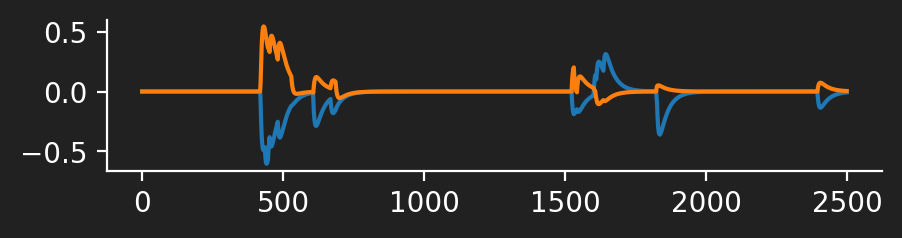

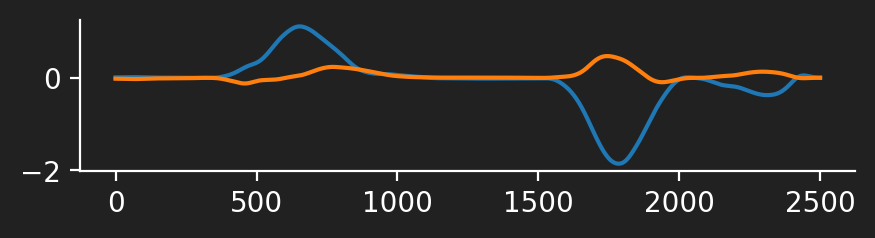

In [45]:
out_rec, other_recs = run_snn(x_train[0:batch_size_train,:,:])

plt.figure(figsize=(5,1),dpi=200)
plt.plot(out_rec[0,:,:].detach().cpu().numpy())
sns.despine()
plt.show()
plt.figure(figsize=(5,1),dpi=200)
plt.plot(y_train[0,:,:].detach().cpu().numpy())
sns.despine()
plt.show()

Define the training parameters

/usr/local/lib/python3.7/dist-packages/matplotlib/legend.py:500: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if facecolor == 'inherit':


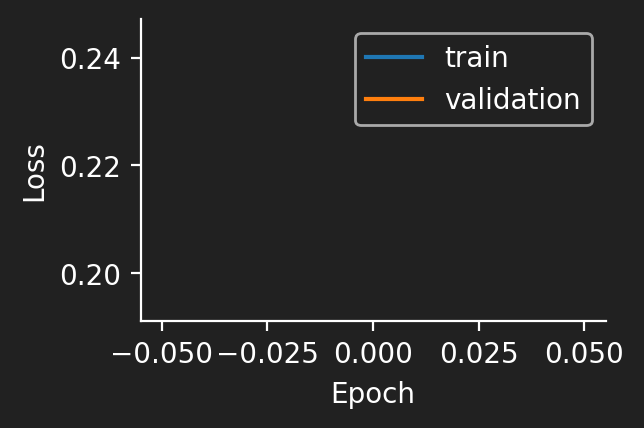

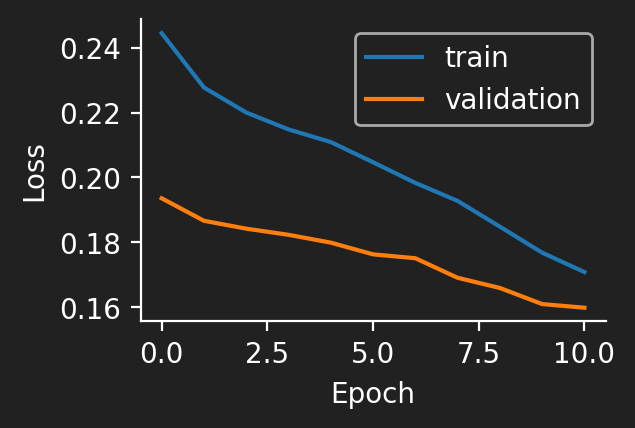

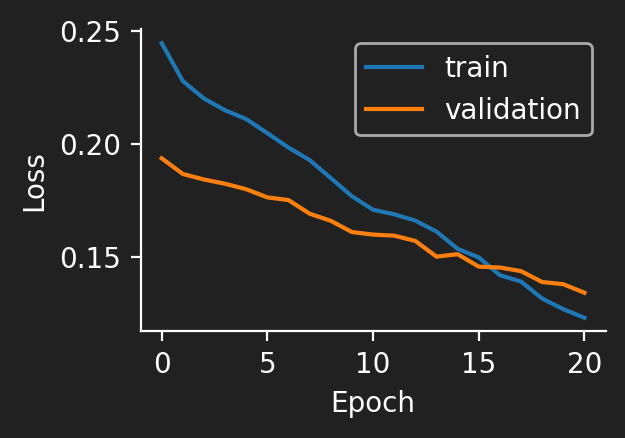

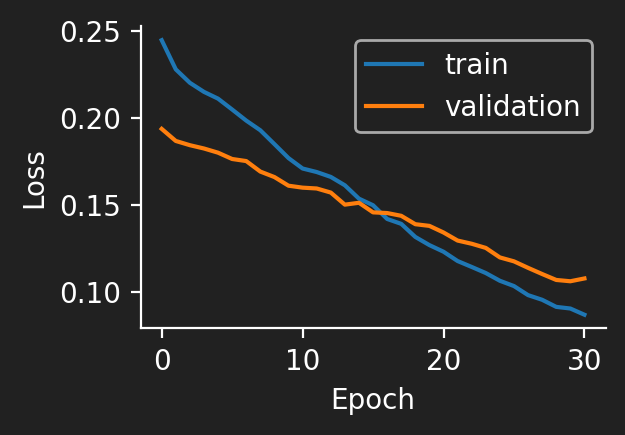

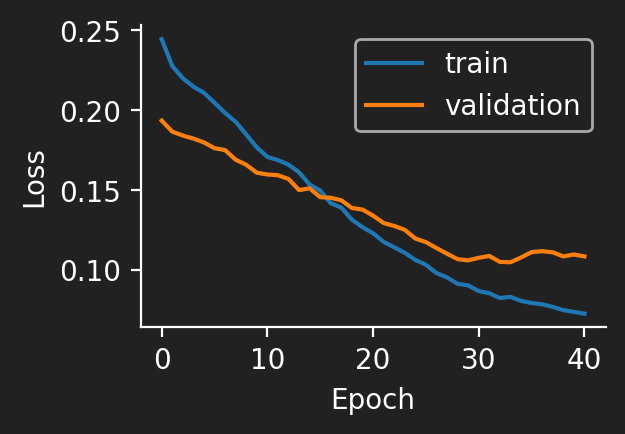

In [46]:
lr = 1e-3
params = [w1,w2,alpha,beta] # 
optimizer = torch.optim.AdamW(params, lr=lr, betas=(0.9,0.999))
loss_fn = nn.MSELoss()
epoch_num = 50

Loss_train = []
Loss_test = []
for epoch in range(0,epoch_num):
  out_rec_train, other_recs_train = run_snn(x_train[0:batch_size_train,:,:])
  loss_x = loss_fn(out_rec_train[0:batch_size_train,:,0],y_train[0:batch_size_train,:,0])
  loss_y = loss_fn(out_rec_train[0:batch_size_train,:,1],y_train[0:batch_size_train,:,1])
  loss = loss_x + loss_y
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  Loss_train.append(loss.item())
  out_rec_test, other_recs_test = run_snn(x_test[0:batch_size_test,:,:])
  loss_x_test = loss_fn(out_rec_test[0:batch_size_test,:,0],y_test[0:batch_size_test,:,0])
  loss_y_test = loss_fn(out_rec_test[0:batch_size_test,:,1],y_test[0:batch_size_test,:,1])
  loss = loss_x_test + loss_y_test
  Loss_test.append(loss.item())
  if epoch % 10 == 0:
    plt.figure(figsize=(3,2),dpi=200)
    plt.plot(Loss_train,label='train')
    plt.plot(Loss_test,label='validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    sns.despine()
    plt.show()



In [47]:
v

tensor([[-0.0539,  0.0310, -0.0072,  ..., -0.0311, -0.0075, -0.0277],
        [-0.0201,  0.0280,  0.0514,  ..., -0.0037,  0.0434,  0.0176],
        [-0.0427, -0.0515, -0.0416,  ..., -0.0228,  0.0176, -0.0050],
        ...,
        [-0.0079, -0.0458, -0.0269,  ...,  0.0333, -0.0217,  0.0414],
        [ 0.0434, -0.0507, -0.0061,  ..., -0.0004,  0.0168, -0.0484],
        [ 0.0322, -0.0391, -0.0188,  ..., -0.0455,  0.0079,  0.0345]],
       device='cuda:0', requires_grad=True)

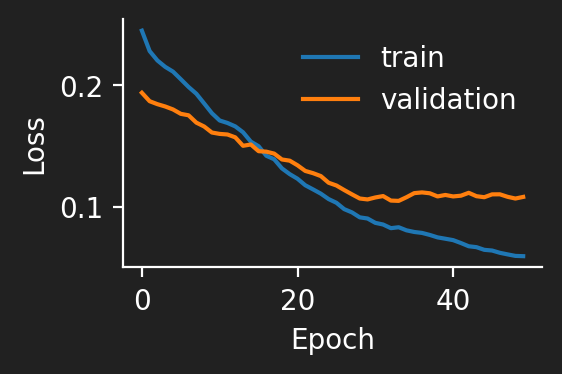

In [91]:
LIGHT = 'white'
DARK = np.array([33, 33, 33])/255
ORANGE = np.array([219, 97, 0]) / 255
BLUE = np.array([31, 119, 180]) / 255

plt.rcParams['text.color'] = LIGHT
plt.rcParams['axes.labelcolor'] = LIGHT
plt.rcParams['axes.labelcolor'] = LIGHT
plt.rcParams['xtick.color'] = LIGHT
plt.rcParams['ytick.color'] = LIGHT
plt.rcParams['figure.facecolor'] = DARK
plt.rcParams['axes.facecolor'] = DARK
plt.rcParams['axes.edgecolor'] = LIGHT
plt.rcParams['legend.facecolor'] = DARK

plt.figure(figsize=(3,2),dpi=200)
plt.plot(Loss_train,label='train')
plt.plot(Loss_test,label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig('recurrent_loss.jpeg')

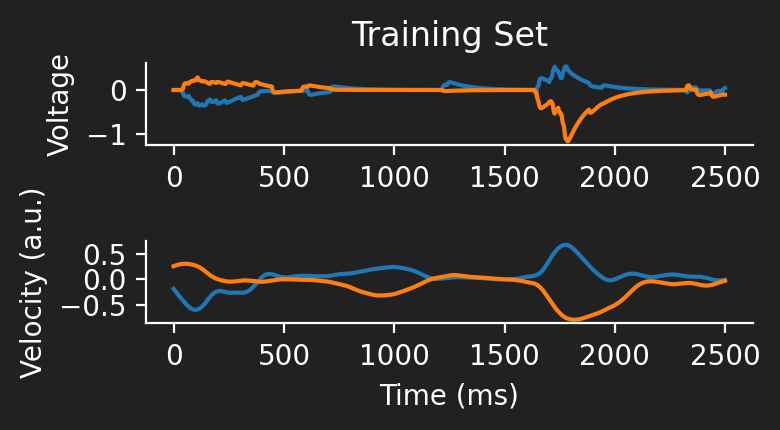

In [100]:
batch_id = 20
plt.figure(figsize=(4,2.25),dpi=200)
plt.subplot(2, 1, 1)
plt.title('Training Set')
plt.plot(out_rec_train[batch_id,:,0].detach().cpu().numpy(),label='Neuron 1')
plt.plot(out_rec_train[batch_id,:,1].detach().cpu().numpy(),label='Neuron 2')
sns.despine()
#plt.legend(frameon=False)
plt.ylabel('Voltage')

plt.subplot(2, 1, 2)
plt.plot(y_train[batch_id,:,0].detach().cpu().numpy(),label='$x$')
plt.plot(y_train[batch_id,:,1].detach().cpu().numpy(),label='$y$')
sns.despine()
#plt.legend(frameon=False)
plt.xlabel('Time (ms)')
plt.ylabel('Velocity (a.u.)')

plt.tight_layout()


plt.savefig('rec_train_set.png')
plt.savefig('rec_train_set.jpeg')

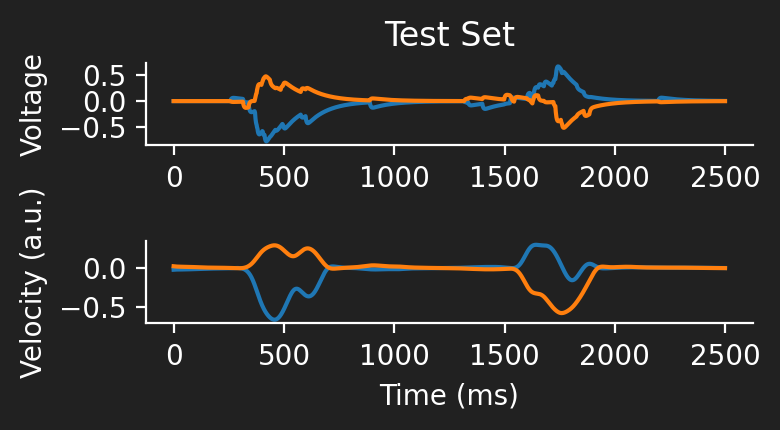

In [102]:
batch_id = 20
plt.figure(figsize=(4,2.25),dpi=200)
plt.subplot(2, 1, 1)
plt.title('Test Set')
plt.plot(out_rec_test[batch_id,:,0].detach().cpu().numpy(),label='Neuron 1')
plt.plot(out_rec_test[batch_id,:,1].detach().cpu().numpy(),label='Neuron 2')
sns.despine()
#plt.legend(frameon=False)
plt.ylabel('Voltage')

plt.subplot(2, 1, 2)
plt.plot(y_test[batch_id,:,0].detach().cpu().numpy(),label='$x$')
plt.plot(y_test[batch_id,:,1].detach().cpu().numpy(),label='$y$')
sns.despine()
#plt.legend(frameon=False)
plt.xlabel('Time (ms)')
plt.ylabel('Velocity (a.u.)')

plt.tight_layout()

plt.savefig('rec_test_set.png')
plt.savefig('rec_test_set.jpeg')
plt.savefig('rec_test_set.svg')

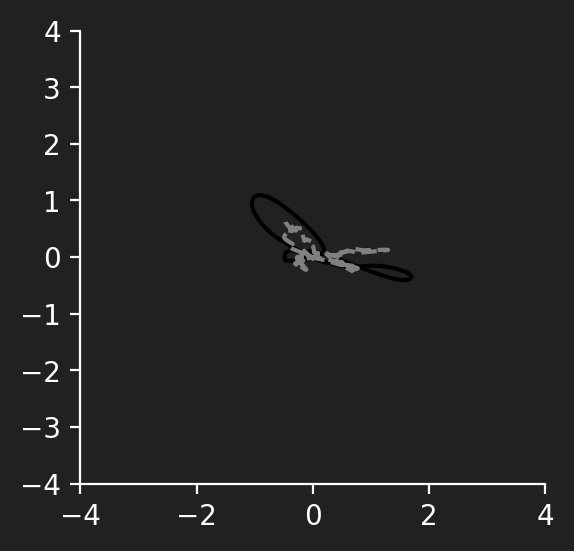

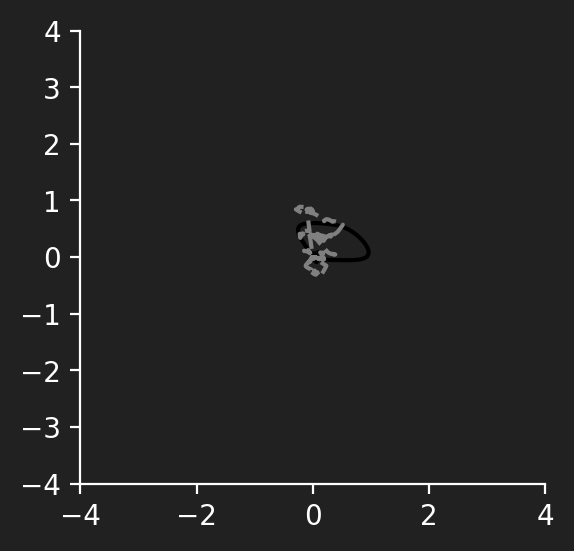

In [54]:
batch_id = 11
plt.figure(figsize=(3,3),dpi=200)
plt.plot(y_train[batch_id,:,0].detach().cpu().numpy(),y_train[batch_id,:,1].detach().cpu().numpy(),'k')
plt.plot(out_rec_train[batch_id,:,0].detach().cpu().numpy(),out_rec_train[batch_id,:,1].detach().cpu().numpy(),'--',color='gray')
plt.xlim([-4.0, 4.0])
plt.ylim([-4.0, 4.0])
sns.despine()
plt.show()

plt.figure(figsize=(3,3),dpi=200)
plt.plot(y_test[batch_id,:,0].detach().cpu().numpy(),y_test[batch_id,:,1].detach().cpu().numpy(),'k')
plt.plot(out_rec_test[batch_id,:,0].detach().cpu().numpy(),out_rec_test[batch_id,:,1].detach().cpu().numpy(),'--',color='gray')
plt.xlim([-4.0, 4.0])
plt.ylim([-4.0, 4.0])
sns.despine()
plt.show()

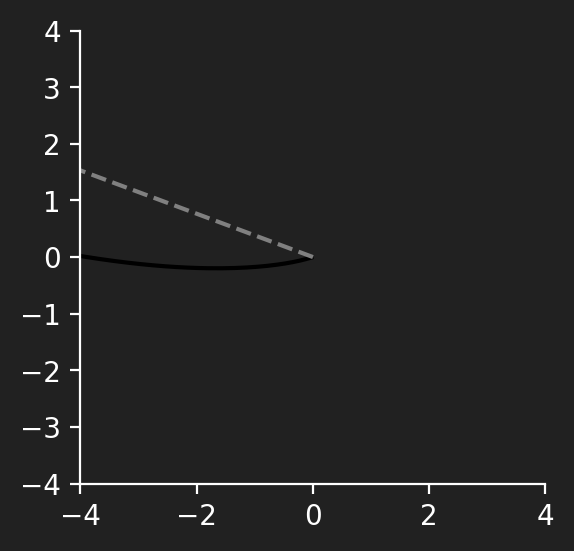

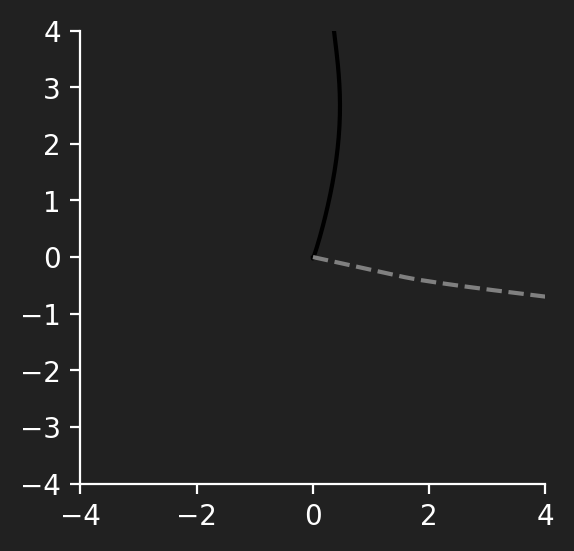

In [55]:
batch_id = 11
plt.figure(figsize=(3,3),dpi=200)
plt.plot(torch.cumsum(y_train[batch_id,:,0],dim=0).detach().cpu().numpy(),torch.cumsum(y_train[batch_id,:,1],dim=0).detach().cpu().numpy(),'k')
plt.plot(torch.cumsum(out_rec_train[batch_id,:,0],dim=0).detach().cpu().numpy(),torch.cumsum(out_rec_train[batch_id,:,1],dim=0).detach().cpu().numpy(),'--',color='gray')
plt.xlim([-4.0, 4.0])
plt.ylim([-4.0, 4.0])
sns.despine()
plt.show()

plt.figure(figsize=(3,3),dpi=200)
plt.plot(torch.cumsum(y_test[batch_id,:,0],dim=0).detach().cpu().numpy(),torch.cumsum(y_test[batch_id,:,1],dim=0).detach().cpu().numpy(),'k')
plt.plot(torch.cumsum(out_rec_test[batch_id,:,0],dim=0).detach().cpu().numpy(),torch.cumsum(out_rec_test[batch_id,:,1],dim=0).detach().cpu().numpy(),'--',color='gray')
plt.xlim([-4.0, 4.0])
plt.ylim([-4.0, 4.0])
sns.despine()
plt.show()